# Install Dependencies

In [ ]:
# Environment created for tensorflow=2.10

!pip install gym
!pip install keras
!pip install keras-rl2
!pip install matplotlib

# Import libraries

In [1]:
from gym import Env
from gym.spaces import Discrete, Box

import numpy as np
import random
import matplotlib.pyplot as plt
import os
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Create our class

In [2]:
class CoffeeEnv(Env):
    
    ''' 
    Define class and inherit methods and properties from OpenAI gym class
    
    '''
    
    def __init__(self):

        # Stove off == 0, stove on == 1
        self.action_space = Discrete(2)
        # Temperature array from 0 to 120 Celsius degrees continuous values
        self.observation_space = Box(low=np.array([0], dtype=np.float32), high=np.array([120], dtype=np.float32))
        # Starting temperature 
        self.state = random.randint(10, 50)
        # Brew length in seconds (4 minutes)
        self.brew_length = 240
    
    
    def step(self, action):
        
        '''
        We assume linear correlation between stove on/off and water temperature for simplicity purpose
        An action happens every second which changes the temperature for 1 degree
        
        '''
        if action == 0: # Stove off
            self.state -= 1 # Temperature decreases 1 degree
        elif action == 1: # Stove on
            self.state += 1 # Temperature increases 1 degree
        
        # Reduce time 
        self.brew_length -= 1
  

        '''
        The further away we are from the optimal temperature range, the lower the reward will be
        
        '''
        # Calculate the reward
        if self.state >= 90 and self.state <= 96: # Optimal temperature range
            reward = 1
        elif self.state < 90:
            reward = self.state/120 - 1
        else:
            reward = -self.state/120
        
        # Check if the time limit is done
        if self.brew_length <= 0:
            done = True
        else:
            done = False
        
        # Apply some flactuations to temperature (eg from environmental causes)
        self.state += random.randint(-1, 1)
        
        # Set a placeholder for information
        info = {}
            
        return self.state, reward, done, info
            
               
    def render(self):
        pass
    
    
    def reset(self):
        
        # Reset the environment
        self.state = random.randint(10, 50)
        self.brew_length = 240
        
        return self.state

## Create a new instance of our custom environment

In [5]:
env = CoffeeEnv()

In [22]:
print(' action_space :', env.action_space, '\n', 
      'observation_space :', env.observation_space, '\n')

print(' action_space sample :', env.action_space.sample(), '\n', 
      'observation_space sample :', env.observation_space.sample())

 action_space : Discrete(2) 
 observation_space : Box(0.0, 120.0, (1,), float32) 

 action_space sample : 1 
 observation_space sample : [58.002285]


## Try some random actions

In [8]:
episodes = 10 # Making 10 different coffees

for episode in range(1, episodes + 1):
    
    state = env.reset() # Reset our environment
    done = False
    score = 0
    
    
    while not done:
        
        # env.render()
        action =  env.action_space.sample() # get random action
        observation, reward, done, info = env.step(action) # do the random action
        score += reward # Add the reward
        
    print('Episode : {}, Score : {}'.format(episode, score))

Episode : 1, Score : -168.89166666666668
Episode : 2, Score : -203.04999999999984
Episode : 3, Score : -203.49166666666656
Episode : 4, Score : -101.00000000000004
Episode : 5, Score : -226.69999999999987
Episode : 6, Score : -211.4999999999997
Episode : 7, Score : -118.15833333333323
Episode : 8, Score : -214.94999999999985
Episode : 9, Score : -135.15000000000003
Episode : 10, Score : -164.70000000000005


#### Our barista agent is quite bad as it is randomly opens and closes our stove. Wouldn't recommend

## Lets build our Deep Learning model

In [14]:
actions = env.action_space.n
states = env.observation_space.shape

print('Actions : {}, States : {}'.format(actions, states))

Actions : 2, States : (1,)


In [10]:
try:
    del model
except:
    pass

In [11]:
model = Sequential()
model.add(Dense(12, activation='relu', input_shape=states))
model.add(Dense(12, activation='relu'))
model.add(Dense(actions, activation='linear'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                24        
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 dense_2 (Dense)             (None, 2)                 26        
                                                                 
Total params: 206
Trainable params: 206
Non-trainable params: 0
_________________________________________________________________


## Lets build our Agent

In [11]:
'''
We dont want our agent to focus much on exploration as the path to make a good coffee is pretty clear.
We use BoltzmannQPolicy instead of EpsGreedyQPolicy as the approach of choosing an action based on weighted probabilities,
    seems more robust for our problem.
    
We give a big limit to sequential memory, there is room to give it less for making the training process faster without
    worrying about overfitting to new data but we will leave it at that for now.
Window length is fine at value 1 as our data dont have any complexity

For the agent we gave warmup steps value 10, which is low and sample with replacment will happen in the training, but it wont be
    a problem for our agent, because of the way we made the rewards to be lower the further we are from the optimal range.
    A more optimal value would be ~10^2
Finally we set target_model_update=100, a reasonable value to update our models values every 100 steps,
    for computation speed and to avoid overfitting

'''

policy = BoltzmannQPolicy()
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model, policy=policy, memory=memory,
               nb_actions=actions, nb_steps_warmup=100, target_model_update=100)

## Compile and train

In [14]:
'''
Adam optimizer and mean absolute error metric, training steps=200.000

'''

dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
history = dqn.fit(env, nb_steps=200000, visualize=False, verbose=1)

Training for 200000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 32:53 - reward: -0.6750

C:\Users\jwild\miniconda3\envs\coffee_env\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\jwild\miniconda3\envs\coffee_env\lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 128s 13ms/step - reward: -0.7159
41 episodes - episode_reward: -171.856 [-259.783, -94.192] - loss: 1.135 - mae: 11.507 - mean_q: -22.457

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 128s 13ms/step - reward: -0.3217
42 episodes - episode_reward: -77.975 [-270.825, 59.742] - loss: 1.364 - mae: 11.732 - mean_q: -22.464

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 125s 12ms/step - reward: -0.4658
42 episodes - episode_reward: -112.208 [-147.042, -44.783] - loss: 0.681 - mae: 7.154 - mean_q: -13.215

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 129s 13ms/step - reward: -0.4595
41 episodes - episode_reward: -109.669 [-167.167, -32.108] - loss: 0.616 - mae: 6.421 - mean_q: -10.268

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 131s 13ms/step - reward: -0.4378
42 episodes - episode_reward: -105.421 [

# Testing

In [15]:
'''
Test for 20 coffees

'''

scores = dqn.test(env, nb_episodes=20, visualize=False)
print('\n', 'Rewards Mean :', np.mean(scores.history['episode_reward']))

Testing for 20 episodes ...
Episode 1: reward: 120.267, steps: 240
Episode 2: reward: 137.350, steps: 240
Episode 3: reward: 159.833, steps: 240
Episode 4: reward: 161.592, steps: 240
Episode 5: reward: 152.100, steps: 240
Episode 6: reward: 180.183, steps: 240
Episode 7: reward: 176.942, steps: 240
Episode 8: reward: 150.117, steps: 240
Episode 9: reward: 179.742, steps: 240
Episode 10: reward: 157.417, steps: 240
Episode 11: reward: 133.558, steps: 240
Episode 12: reward: 124.708, steps: 240
Episode 13: reward: 127.758, steps: 240
Episode 14: reward: 175.775, steps: 240
Episode 15: reward: 126.008, steps: 240
Episode 16: reward: 117.408, steps: 240
Episode 17: reward: 136.117, steps: 240
Episode 18: reward: 124.342, steps: 240
Episode 19: reward: 119.692, steps: 240
Episode 20: reward: 137.350, steps: 240

 Rewards Mean : 144.91291666666666


## Save our model

In [16]:
model.save("D:\\data_projects\\coffee_rl\\my_model_coffee")

INFO:tensorflow:Assets written to: D:\data_projects\coffee_rl\my_model_coffee\assets


## Load the model and recreate our agent

In [3]:
model = keras.models.load_model("D:\\data_projects\\coffee_rl\\my_model_coffee")

In [4]:
env = CoffeeEnv()

actions = env.action_space.n
states = env.observation_space.shape

In [5]:
policy = BoltzmannQPolicy()
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model, policy=policy, memory=memory,
               nb_actions=actions, nb_steps_warmup=100, target_model_update=100)

# Make some coffees

In [6]:
info_dict = {}

episodes = 10 # Making 10 different coffees

for episode in range(1, episodes + 1):
    
    state = env.reset() # Reset our environment
    done = False
    score = 0
    
    info_list = []
    
    while not done:
        
        # env.render()
        action = dqn.forward(state) # predict action
        observation, reward, done, info = env.step(action) # do the predicted action
        score += reward
        
        info_list.append(observation)
        
    info_dict['Episode_' + str(episode)] = info_list
        
    print('Episode : {}, Score : {}'.format(episode, score))

C:\Users\jwild\miniconda3\envs\coffee_env\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode : 1, Score : 161.15
Episode : 2, Score : 128.61666666666667
Episode : 3, Score : 121.90000000000003
Episode : 4, Score : 118.94999999999999
Episode : 5, Score : 112.06666666666669
Episode : 6, Score : 138.90833333333333
Episode : 7, Score : 125.55000000000001
Episode : 8, Score : 178.13333333333333
Episode : 9, Score : 147.24166666666667
Episode : 10, Score : 142.03333333333333


# Visualize the results (10 coffee attempts by our agent barista)

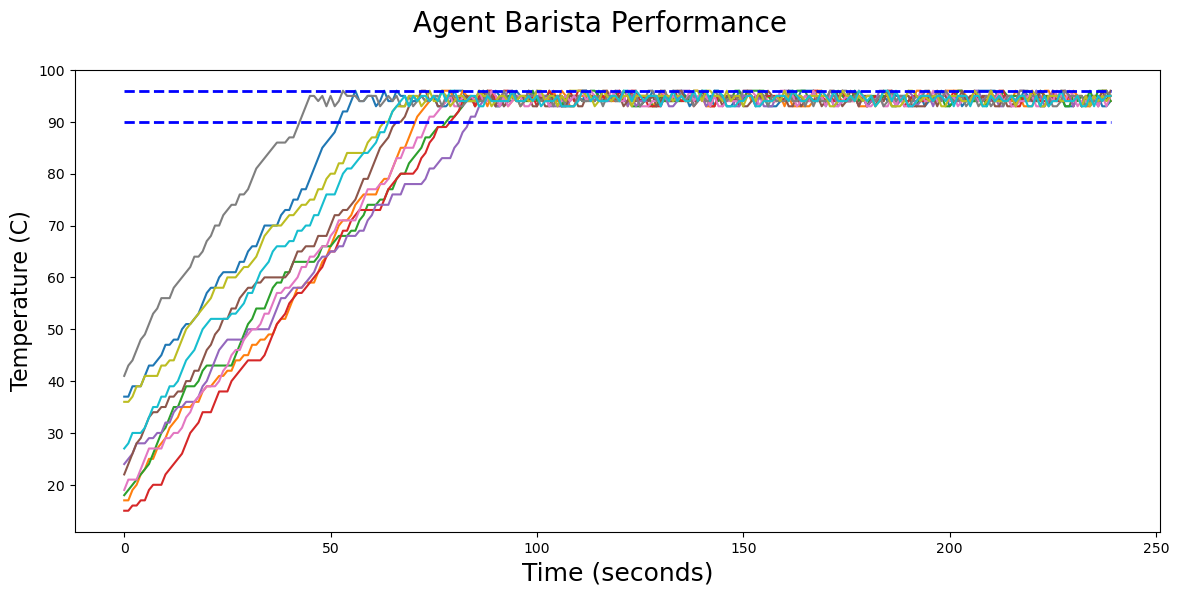

In [15]:
plt.figure(figsize=(14, 6))

for k in info_dict.keys():
    plt.plot(info_dict[k])
    
plt.plot(np.repeat(90, 240), 'b--', linewidth=2)
plt.plot(np.repeat(96, 240), 'b--', linewidth=2)

plt.suptitle('Agent Barista Performance', fontsize=20)
plt.xlabel('Time (seconds)', fontsize=18)
plt.ylabel('Temperature (C)', fontsize=16);